# Import Packages

In [15]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree  
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

# Import Data

In [16]:
# Can have as many cells as you want for code
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet

# Function

In [17]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    
    '''DO NOT REMOVE THIS FUNCTION.

    The function accepts a dataframe as input and returns an iterable (list)
    of binary classes as output.

    The function is coded to test on hidden data and includes any preprocessing
    functions needed for the model to perform. 
    
    All relevant code MUST be included in this function.
    '''
    
    ### 1. DATA CLEANING  ###
    
    

    df = pd.read_parquet(filepath)
    # Calculate age and interaction time for non-None values
    df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'], errors='coerce')
    mask = ~df['cltdob_fix'].isnull()
    df.loc[mask, 'age'] = (datetime.now() - df.loc[mask, 'cltdob_fix'])
    df['age'] = df['age'] / pd.Timedelta(days=365.25)
    df['min_occ_date'] = pd.to_datetime(df['min_occ_date'], errors='coerce')
    mask_occ_date = ~df['min_occ_date'].isnull()
    df.loc[mask_occ_date, 'interaction_time'] = (datetime.now() - df.loc[mask_occ_date, 'min_occ_date'])
    df['interaction_time'] = df['interaction_time'] / pd.Timedelta(days=365.25)

    # Replace NaN in 'age' and 'interaction_time' with mean
    mean_age = df['age'].mean()
    mean_interaction_time = df['interaction_time'].mean()
    df['age'].fillna(mean_age, inplace=True)
    df['interaction_time'].fillna(mean_interaction_time, inplace=True)

    # Map 'Female' to 0 and 'Male' to 1 in 'cltsex_fix'
    df['cltsex_fix'] = df['cltsex_fix'].map({'Female': 0, 'Male': 1})
    df['cltsex_fix'] = df['cltsex_fix'].fillna(0.5)

    # One-hot encode the 'race_desc' column and ordinal encode the 'ctrycode_desc' column
    undefined_ctrycode = ['Not Applicable', 'Unknown Country Code']
    df['ctrycode_desc'] = np.where(df['ctrycode_desc'].isin(undefined_ctrycode), None, df['ctrycode_desc'])
    columns_to_ordinally_encode = ['ctrycode_desc', 'clttype', 'stat_flag', 'annual_income_est']
    ordinal_encoder = OrdinalEncoder()
    df[columns_to_ordinally_encode] = ordinal_encoder.fit_transform(df[columns_to_ordinally_encode])
    df = pd.get_dummies(df, columns=['race_desc'])
    df[columns_to_ordinally_encode] = df[columns_to_ordinally_encode].fillna(df[columns_to_ordinally_encode].mean())

    # Replace NaN values in the consent columns with 0.5
    columns_flags_and_consent = ['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term', 'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail', 'is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email', 'is_housewife_retiree', 'is_sg_pr', 'is_class_1_2']
    df[columns_flags_and_consent] = df[columns_flags_and_consent].fillna(0.5)

    # Replace NaN in metrics related to household size and population with mean
    df['hh_20'] = pd.to_numeric(df['hh_20'], errors='coerce')
    df['hh_20'].fillna(df['hh_20'].mean(), inplace=True)
    df['pop_20'] = pd.to_numeric(df['pop_20'], errors='coerce')
    df['pop_20'].fillna(df['pop_20'].mean(), inplace=True)
    df['hh_size'] = pd.to_numeric(df['hh_size'], errors='coerce')
    df['hh_size'].fillna(df['hh_size'].mean(), inplace=True)
    df['hh_size_est'] = pd.to_numeric(df['hh_size_est'], errors='coerce')
    df['hh_size_est'].fillna(df['hh_size_est'].mean(), inplace=True)

    # Replace NaN values in 'recency_lapse', 'recency_cancel', 'tot_inforce_pols' with the mean of non-NaN values
    mean_recency_lapse = df['recency_lapse'].mean()
    df['recency_lapse'].fillna(mean_recency_lapse, inplace=True)
    mean_recency_cancel = df['recency_cancel'].mean()
    df['recency_cancel'].fillna(mean_recency_cancel, inplace=True)
    mean_tot_inforce_pols = df['tot_inforce_pols'].mean()
    df['tot_inforce_pols'].fillna(mean_tot_inforce_pols, inplace=True)

    # Replace None values in 'f_ever_declined_la' with 0
    df['f_ever_declined_la'].fillna(0, inplace=True)

    # Replace None values in 'f_purchase_lh' with 0
    df['f_purchase_lh'].fillna(0, inplace=True)




    ### 2. DATA SELECTION  ###



    column_indices = list(range(1, 37)) + list(range(1, 37)) + list(range(302, len(df.columns)))
    selected_columns = df.iloc[:, column_indices]
    df = selected_columns
    columns_to_remove = ['min_occ_date', 'cltdob_fix']
    df = df.drop(columns=columns_to_remove, axis=1)
    df = df.replace({False: 0, True: 1})



    ### 3. DATA BALANCING  ###



    majority = df[df['f_purchase_lh'] == 0]
    minority = df[df['f_purchase_lh'] == 1].sample(n = majority.shape[0], replace=True)
    df = pd.concat([minority, majority], axis=0)



    ### 4. Graphs 


    plt.figure(figsize=(6, 4))
    sns.countplot(x='f_purchase_lh', data=df)
    plt.title('Distribution of Target Variable')
    plt.show()
    
    ### 5. Model ###
    
    
    X = df.drop('f_purchase_lh', axis=1)
    y = df['f_purchase_lh']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=1989)

    # Initialize the decision tree classifier
    dt_model = DecisionTreeClassifier(random_state=42)
    
    
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5)

    # Print cross-validation scores
    print(f'Cross-Validation Scores: {cv_scores}')
    print(f'Mean Accuracy: {cv_scores.mean()}')

    # Train the model on the entire training set
    dt_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = dt_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test Set Accuracy: {accuracy}')

    # Print classification report for more detailed metrics
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    classification_rep = classification_report(y_test, y_pred)
    
    # Generate and display a confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Purchased', 'Purchased'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate and display an ROC curve
    y_prob = dt_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    # Plot the decision tree
    plt.figure(figsize=(15, 10))
    plot_tree(dt_model, filled=True, feature_names=X.columns.tolist(), class_names=['Not Purchased', 'Purchased'], rounded=True, max_depth=2)
    plt.show()
    result = [y_pred]
    
    return result

# Cell to check testing_hidden_data function

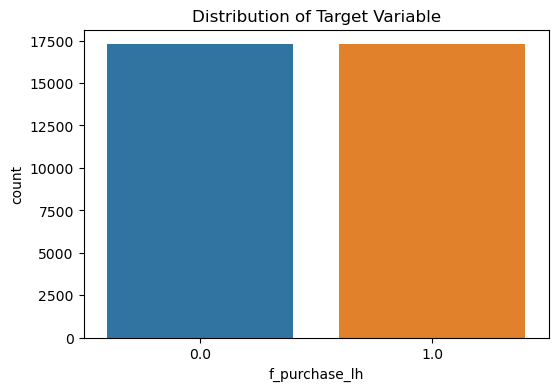

Cross-Validation Scores: [0.71556604 0.80676101 0.77327044 0.72731562 0.82324265]
Mean Accuracy: 0.7692311496309395
Test Set Accuracy: 0.8065798987707882
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80      1394
         1.0       0.79      0.83      0.81      1372

    accuracy                           0.81      2766
   macro avg       0.81      0.81      0.81      2766
weighted avg       0.81      0.81      0.81      2766



<Figure size 800x600 with 0 Axes>

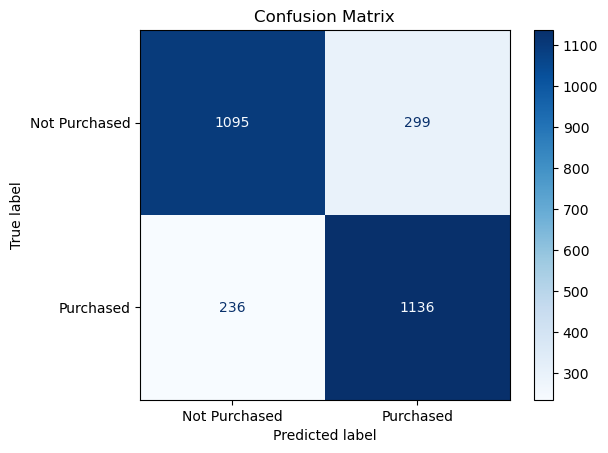

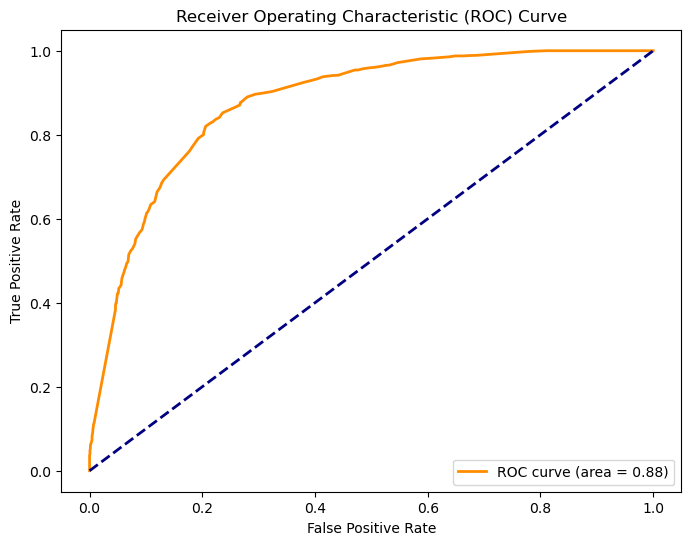

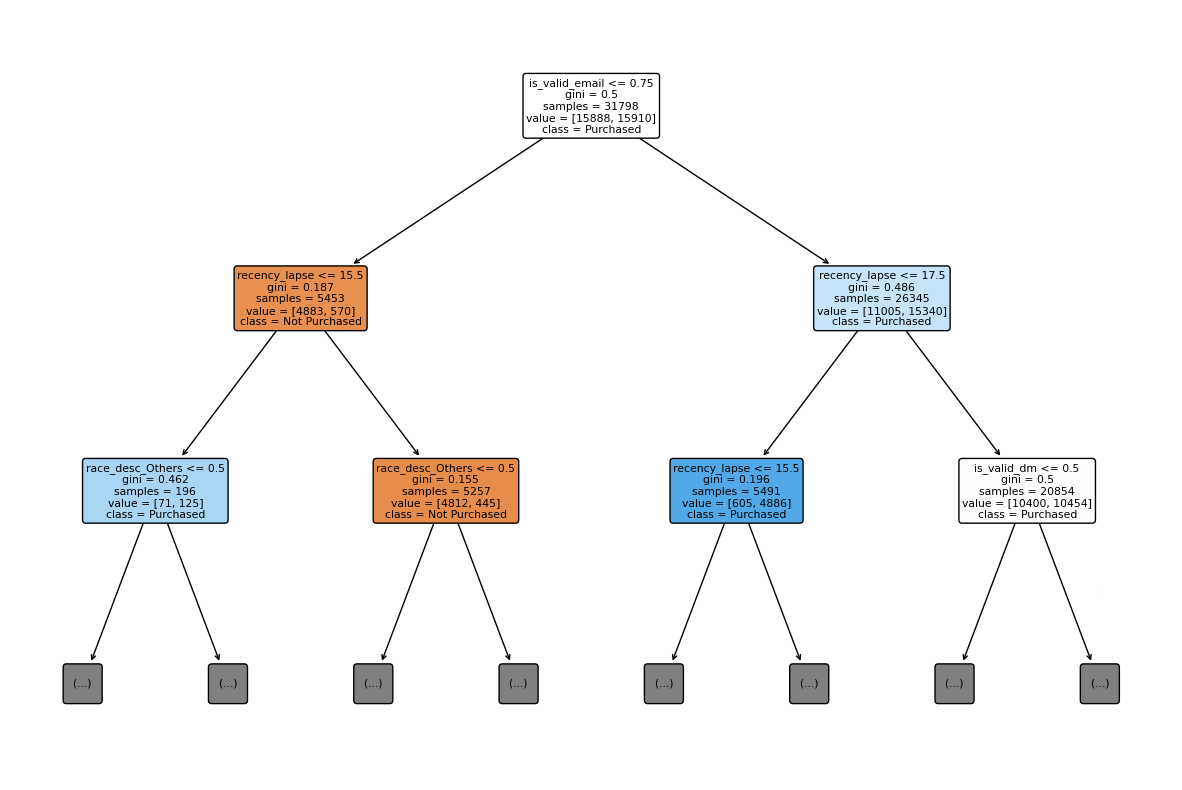

[array([1., 1., 0., ..., 0., 0., 1.])]


In [18]:
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))